In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf 
from tensorflow import keras

from sklearn.manifold import TSNE

In [2]:
df = pd.read_csv('classification_cleaned.csv')
df.head()

,alpha,delta,class,redshift,photometric_filters
0,135.689107,32.494632,0,0.634794,21.442149
1,144.826101,31.274185,0,0.779136,22.930232
2,142.188790,35.582444,0,0.644195,22.024390
3,338.741038,-0.402828,0,0.932346,21.779020
4,345.282593,21.183866,0,0.116123,17.395478


In [3]:
df.describe()

,alpha,delta,class,redshift,photometric_filters
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,177.629117,24.135305,0.621490,0.576661,20.311896
std,96.502241,19.644665,0.816778,0.730707,21.231872
min,0.005528,-18.785328,0.000000,-0.009971,-6669.000165
25%,127.518222,5.146771,0.000000,0.054517,18.906512
50%,180.900700,23.645922,0.000000,0.424173,20.894890
75%,233.895005,39.901550,1.000000,0.704154,21.794779
max,359.999810,83.000519,2.000000,7.011245,28.411403


In [4]:
# I am going to separate features and target columns 
X = df.drop('class', axis=1).values
y = df['class'].values

In [5]:
# My class column is imbalanced, so I should handle it
# For handling imbalanced data, there are many ways like oversampling, undersampling, SMOTE and  Class Weights
# I prefer to go with  Weighted Classes that model can pay more attention to the QSO and star 
# I need to find all the unique class labels in my target column 
# for calculating the weights of each class that QSO and star can get more weight
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)
# QSO is 1 and it's weight is 1.757 
# Source : https://machinelearningmastery.com/5-effective-ways-to-handle-imbalanced-data-in-machine-learning/

Class weights: {0: 0.5607424229680097, 1: 1.757994479897333, 2: 1.5436386650612826}


In [6]:
# I am going to split the X and y before scaling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
# Feature Scaling:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# I used stratify=y to maintain class balance in splitting
# Also, I fit the scaler only for training data, then transform validation and test to avoid data leakage
# Scale only learns mean and std from training data
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# Labeling for the model because softmax  gives probabilities for each class
#  One hot encoding let me to  compare these probabilities with true labels using categorical crossentropy
y_train = to_categorical(y_train, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)
print("One hot encoded:", y_train[0])

Training set: (70000, 4)
Validation set: (15000, 4)
Test set: (15000, 4)
One hot encoded: [1. 0. 0.]


<h1><center>Building the Neural Network Architecture</center><h1>

In [7]:
# I am going to build the model now, I will use Sequential model 
model = Sequential()
model.add(Input(shape=(4,))) 
model.add(Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
#model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(12, activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            39 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 323 (1.26 KB)

 Trainable params: 323 (1.26 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Compiling the model:
# I am going to use catergorical crossentropy because it is used for multi class 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(multi_label=False)])
# Early stopping 
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
# Reducing learning rate when stuck
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=7, verbose=1)
# Save best model
checkpoint = ModelCheckpoint('best_astro_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [9]:
# Training the Model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=256, class_weight=class_weight_dict,
                    callbacks=[early_stop, reduce_lr, checkpoint], verbose=1)

Epoch 1/30
255/274 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - accuracy: 0.4468 - auc: 0.6582 - loss: 0.8699
Epoch 1: val_accuracy improved from None to 0.75453, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5748 - auc: 0.7989 - loss: 0.7115 - val_accuracy: 0.7545 - val_auc: 0.9114 - val_loss: 0.5877 - learning_rate: 0.0010
Epoch 2/30
273/274 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - accuracy: 0.7533 - auc: 0.9142 - loss: 0.4625
Epoch 2: val_accuracy improved from 0.75453 to 0.84207, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7787 - auc: 0.9308 - loss: 0.4447 - val_accuracy: 0.8421 - val_auc: 0.9623 - val_loss: 0.3849 - learning_rate: 0.0010
Epoch 3/30
220/274 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.8388 - auc: 0.9575 - loss: 0.4040
Epoch 3: val_accuracy improved from 0.84207 to 0.91027, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8550 - auc: 0.9625 - loss: 0.3461 - val_accuracy: 0.9103 - val_auc: 0.9767 - val_loss: 0.2944 - learning_rate: 0.0010
Epoch 4/30
205/274 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.8803 - auc: 0.9686 - loss: 0.3015
Epoch 4: val_accuracy improved from 0.91027 to 0.92253, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8879 - auc: 0.9715 - loss: 0.3005 - val_accuracy: 0.9225 - val_auc: 0.9795 - val_loss: 0.2680 - learning_rate: 0.0010
Epoch 5/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - accuracy: 0.9017 - auc: 0.9753 - loss: 0.3062
Epoch 5: val_accuracy improved from 0.92253 to 0.92287, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9036 - auc: 0.9759 - loss: 0.2808 - val_accuracy: 0.9229 - val_auc: 0.9803 - val_loss: 0.2574 - learning_rate: 0.0010
Epoch 6/30
271/274 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.9092 - auc: 0.9773 - loss: 0.2490
Epoch 6: val_accuracy improved from 0.92287 to 0.93527, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9140 - auc: 0.9785 - loss: 0.2617 - val_accuracy: 0.9353 - val_auc: 0.9830 - val_loss: 0.2347 - learning_rate: 0.0010
Epoch 7/30
218/274 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.9165 - auc: 0.9793 - loss: 0.2764
Epoch 7: val_accuracy improved from 0.93527 to 0.93587, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9192 - auc: 0.9802 - loss: 0.2427 - val_accuracy: 0.9359 - val_auc: 0.9838 - val_loss: 0.2291 - learning_rate: 0.0010
Epoch 8/30
218/274 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.9225 - auc: 0.9811 - loss: 0.2238
Epoch 8: val_accuracy improved from 0.93587 to 0.93667, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9238 - auc: 0.9816 - loss: 0.2373 - val_accuracy: 0.9367 - val_auc: 0.9840 - val_loss: 0.2284 - learning_rate: 0.0010
Epoch 9/30
265/274 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.9259 - auc: 0.9826 - loss: 0.2181
Epoch 9: val_accuracy improved from 0.93667 to 0.94100, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9265 - auc: 0.9827 - loss: 0.2282 - val_accuracy: 0.9410 - val_auc: 0.9853 - val_loss: 0.2178 - learning_rate: 0.0010
Epoch 10/30
207/274 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - accuracy: 0.9304 - auc: 0.9834 - loss: 0.2125
Epoch 10: val_accuracy did not improve from 0.94100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9305 - auc: 0.9838 - loss: 0.2159 - val_accuracy: 0.9383 - val_auc: 0.9848 - val_loss: 0.2225 - learning_rate: 0.0010
Epoch 11/30
212/274 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.9331 - auc: 0.9844 - loss: 0.2066
Epoch 11: val_accuracy improved from 0.94100 to 0.94287, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9338 - auc: 0.9846 - loss: 0.2072 - val_accuracy: 0.9429 - val_auc: 0.9858 - val_loss: 0.2128 - learning_rate: 0.0010
Epoch 12/30
270/274 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - accuracy: 0.9359 - auc: 0.9851 - loss: 0.2020
Epoch 12: val_accuracy improved from 0.94287 to 0.94307, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9367 - auc: 0.9852 - loss: 0.2019 - val_accuracy: 0.9431 - val_auc: 0.9859 - val_loss: 0.2117 - learning_rate: 0.0010
Epoch 13/30
261/274 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.9379 - auc: 0.9854 - loss: 0.1944
Epoch 13: val_accuracy improved from 0.94307 to 0.94673, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9383 - auc: 0.9858 - loss: 0.1941 - val_accuracy: 0.9467 - val_auc: 0.9866 - val_loss: 0.2023 - learning_rate: 0.0010
Epoch 14/30
269/274 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.9392 - auc: 0.9856 - loss: 0.1933
Epoch 14: val_accuracy improved from 0.94673 to 0.95080, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9399 - auc: 0.9860 - loss: 0.1908 - val_accuracy: 0.9508 - val_auc: 0.9874 - val_loss: 0.1952 - learning_rate: 0.0010
Epoch 15/30
228/274 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - accuracy: 0.9404 - auc: 0.9867 - loss: 0.1891
Epoch 15: val_accuracy improved from 0.95080 to 0.95187, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9415 - auc: 0.9867 - loss: 0.1867 - val_accuracy: 0.9519 - val_auc: 0.9878 - val_loss: 0.1902 - learning_rate: 0.0010
Epoch 16/30
224/274 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.9432 - auc: 0.9869 - loss: 0.1857
Epoch 16: val_accuracy improved from 0.95187 to 0.95367, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9432 - auc: 0.9869 - loss: 0.1843 - val_accuracy: 0.9537 - val_auc: 0.9881 - val_loss: 0.1862 - learning_rate: 0.0010
Epoch 17/30
224/274 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.9441 - auc: 0.9876 - loss: 0.1805
Epoch 17: val_accuracy did not improve from 0.95367
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9440 - auc: 0.9873 - loss: 0.1810 - val_accuracy: 0.9520 - val_auc: 0.9877 - val_loss: 0.1895 - learning_rate: 0.0010
Epoch 18/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - accuracy: 0.9442 - auc: 0.9874 - loss: 0.1805
Epoch 18: val_accuracy improved from 0.95367 to 0.95407, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9448 - auc: 0.9873 - loss: 0.1804 - val_accuracy: 0.9541 - val_auc: 0.9881 - val_loss: 0.1829 - learning_rate: 0.0010
Epoch 19/30
268/274 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.9469 - auc: 0.9876 - loss: 0.1771
Epoch 19: val_accuracy did not improve from 0.95407
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9467 - auc: 0.9876 - loss: 0.1774 - val_accuracy: 0.9531 - val_auc: 0.9878 - val_loss: 0.1873 - learning_rate: 0.0010
Epoch 20/30
268/274 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.9459 - auc: 0.9870 - loss: 0.1799
Epoch 20: val_accuracy improved from 0.95407 to 0.95567, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9476 - auc: 0.9876 - loss: 0.1748 - val_accuracy: 0.9557 - val_auc: 0.9886 - val_loss: 0.1766 - learning_rate: 0.0010
Epoch 21/30
229/274 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - accuracy: 0.9478 - auc: 0.9879 - loss: 0.1747
Epoch 21: val_accuracy did not improve from 0.95567
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9470 - auc: 0.9877 - loss: 0.1740 - val_accuracy: 0.9552 - val_auc: 0.9886 - val_loss: 0.1769 - learning_rate: 0.0010
Epoch 22/30
200/274 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - accuracy: 0.9474 - auc: 0.9879 - loss: 0.1729
Epoch 22: val_accuracy improved from 0.95567 to 0.95713, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9486 - auc: 0.9881 - loss: 0.1710 - val_accuracy: 0.9571 - val_auc: 0.9890 - val_loss: 0.1705 - learning_rate: 0.0010
Epoch 23/30
227/274 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.9494 - auc: 0.9883 - loss: 0.1701
Epoch 23: val_accuracy did not improve from 0.95713
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9489 - auc: 0.9881 - loss: 0.1706 - val_accuracy: 0.9555 - val_auc: 0.9887 - val_loss: 0.1741 - learning_rate: 0.0010
Epoch 24/30
215/274 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.9500 - auc: 0.9886 - loss: 0.1660
Epoch 24: val_accuracy improved from 0.95713 to 0.95827, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9501 - auc: 0.9882 - loss: 0.1685 - val_accuracy: 0.9583 - val_auc: 0.9892 - val_loss: 0.1691 - learning_rate: 0.0010
Epoch 25/30
252/274 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.9513 - auc: 0.9888 - loss: 0.1676
Epoch 25: val_accuracy did not improve from 0.95827
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9498 - auc: 0.9884 - loss: 0.1704 - val_accuracy: 0.9538 - val_auc: 0.9881 - val_loss: 0.1810 - learning_rate: 0.0010
Epoch 26/30
251/274 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.9514 - auc: 0.9883 - loss: 0.1666
Epoch 26: val_accuracy improved from 0.95827 to 0.95860, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9514 - auc: 0.9885 - loss: 0.1656 - val_accuracy: 0.9586 - val_auc: 0.9892 - val_loss: 0.1633 - learning_rate: 0.0010
Epoch 27/30
251/274 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - accuracy: 0.9501 - auc: 0.9889 - loss: 0.1634
Epoch 27: val_accuracy improved from 0.95860 to 0.95887, saving model to best_astro_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9501 - auc: 0.9884 - loss: 0.1656 - val_accuracy: 0.9589 - val_auc: 0.9896 - val_loss: 0.1627 - learning_rate: 0.0010
Epoch 28/30
255/274 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.9525 - auc: 0.9887 - loss: 0.1649
Epoch 28: val_accuracy did not improve from 0.95887
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9513 - auc: 0.9886 - loss: 0.1643 - val_accuracy: 0.9565 - val_auc: 0.9887 - val_loss: 0.1717 - learning_rate: 0.0010
Epoch 29/30
251/274 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - accuracy: 0.9511 - auc: 0.9881 - loss: 0.1678
Epoch 29: val_accuracy did not improve from 0.95887
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9514 - auc: 0.9885 - loss: 0.1643 - val_accuracy: 0.9577 - val_auc: 0.9894 - val_loss: 0.1660 - learning_rate: 0.0010
Epoch 30/30
258/274 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - accuracy: 0.9513 - auc: 0.9890 - loss: 0.1621
Epoch 30: val_accuracy did not improve from 0.95887
274/274 ━━━━━━━━

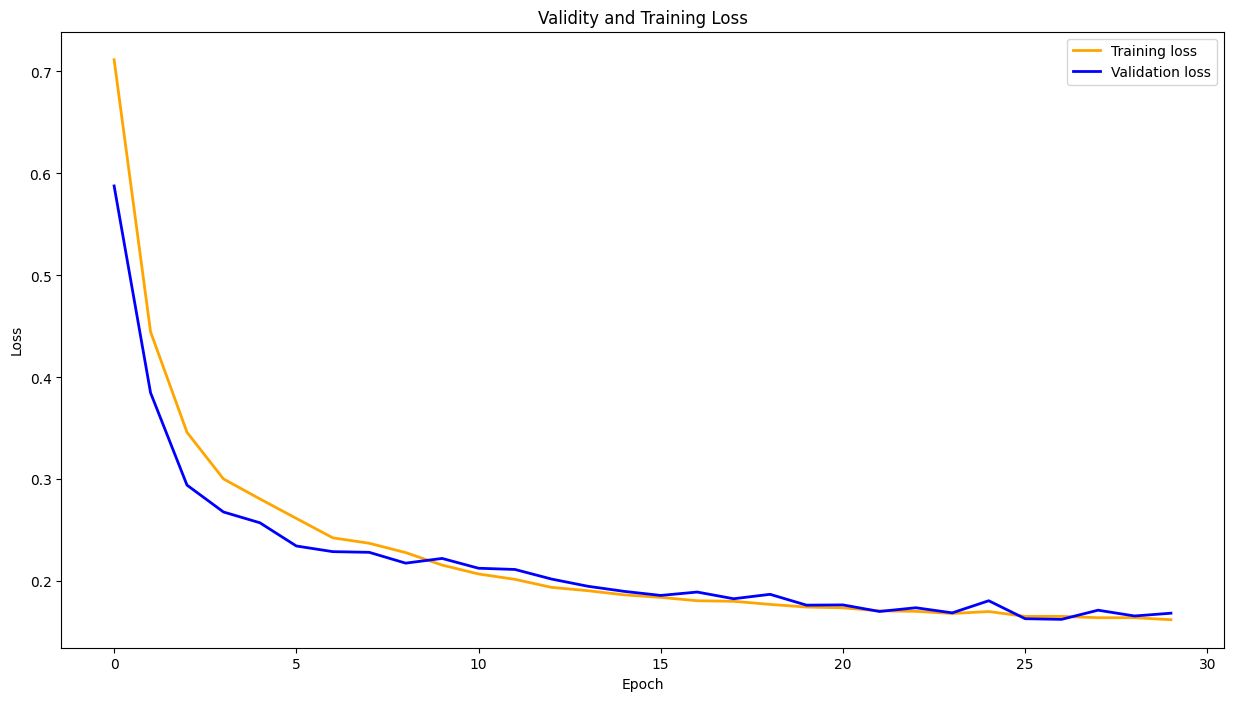

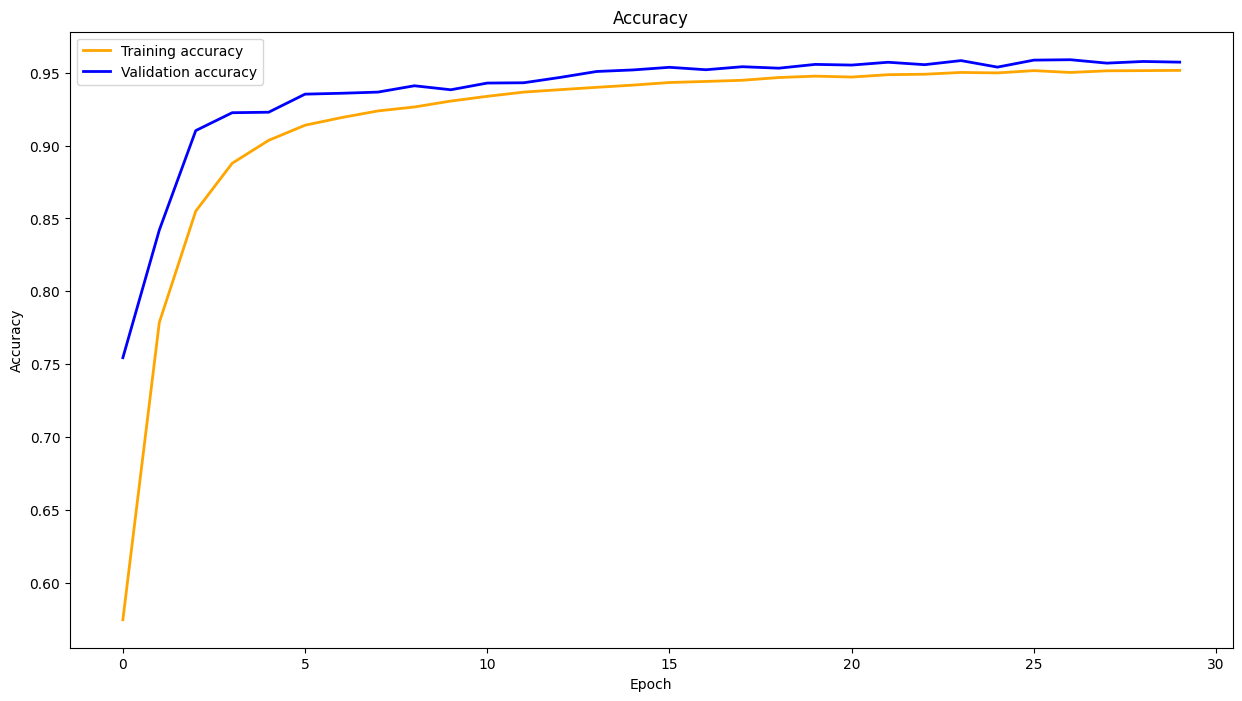

In [10]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(history.history['loss'], label='Training loss', color='orange', linewidth=2, markersize=6)
ax.plot(history.history['val_loss'], label='Validation loss', color='blue', linewidth=2, markersize=6)
ax.set_title('Validity and Training Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(history.history['accuracy'], label='Training accuracy', color='orange', linewidth=2, markersize=6)
ax.plot(history.history['val_accuracy'], label='Validation accuracy', color='blue', linewidth=2, markersize=6)
ax.set_title('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()

# Model learns quickly and  I don t see overfitting
# Val loss and train loss are matching 

In [11]:
# Make predictions
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_test = np.argmax(y_test, axis=1)
# Detailed classification report
print("\nClassification Report:\n")
target_names = ['Star', 'Galaxy', 'QSO']
print(classification_report(y_test, y_pred, target_names=target_names))

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step

Classification Report:

              precision    recall  f1-score   support

        Star       0.97      0.96      0.97      8917
      Galaxy       0.93      0.89      0.91      2844
         QSO       0.96      1.00      0.98      3239

    accuracy                           0.96     15000
   macro avg       0.95      0.95      0.95     15000
weighted avg       0.96      0.96      0.96     15000



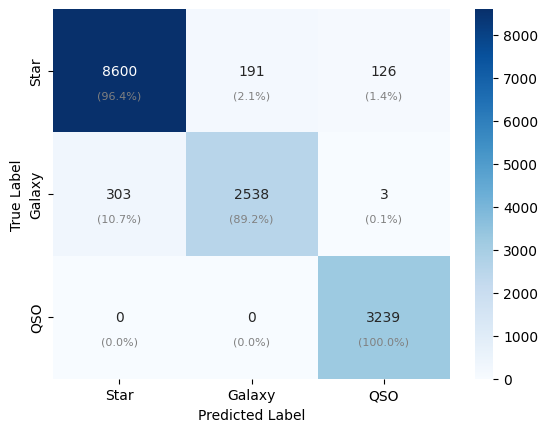

In [12]:
# Confusion Matrix 
confusion_matrix = confusion_matrix(y_test, y_pred)
# After getting the confusion matrix, I need to convert values to float and sum each row of matrix. for dividing each row by its total
# array must be 2D, so I use None to add new axis
confusion_matrix_percent = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, None] * 100
sns.heatmap(confusion_matrix, fmt='d', annot=True, cmap='Blues', xticklabels=target_names, yticklabels=target_names)
# Adding new percentages to the confusion matrix
for  i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.7, f'({confusion_matrix_percent[i, j]:.1f}%)', 
                 ha='center', va='center', fontsize=8, color='gray')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show() 
# I got the code structure from:
# https://stackoverflow.com/questions/20927368/how-to-normalize-a-confusion-matrix
# Almost 11 % of Galaxies are misclassified as stars, I think it is because both have close redshift distributions

In [18]:
#  Calculating Uncertainty Monte Carlo Dropout
predictions = []
# 50 times gernerating predictions

for _ in range(50):
    preds = model(X_test, training=True )
    predictions.append(preds)
# I set up the training=True in the model which means dropout is active during prediction
# The predictions will be different each time because of dropout


# Converting to array and calculating statistics
predictions = np.array(predictions)
mean_pred = np.mean(predictions, axis=0)
# Finding which class has the highest probability
high_probability = np.argmax(mean_pred, axis=1)
std_pred = np.std(predictions, axis=0)
uncertainty = std_pred[np.arange(len(std_pred)), high_probability]
print("Uncertainty in Predictions:\n", uncertainty)
# Source : https://medium.com/biased-algorithms/uncertainty-estimation-in-machine-learning-with-monte-carlo-dropout-72377f5ee276

Uncertainty in Predictions:
 [0.02232758 0.11389975 0.00324451 ... 0.03169277 0.03588613 0.00305523]


In [20]:
high_probability

array([0, 0, 2, ..., 0, 1, 1], dtype=int64)

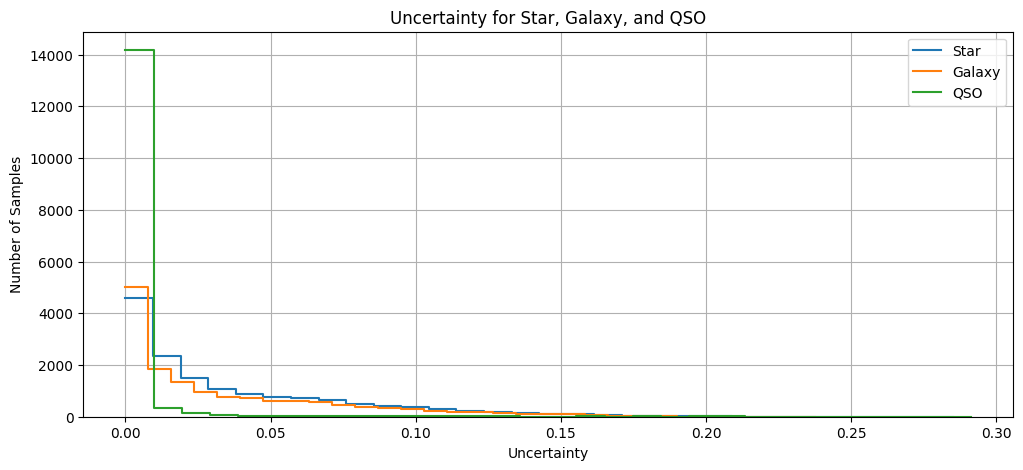

In [19]:
# Visualizing uncertainty 
plt.figure(figsize=(12, 5))
for i in range(3):
    sns.histplot(std_pred[:, i], label=target_names[i], bins=30, element='step', fill=False)
plt.title('Uncertainty for Star, Galaxy, and QSO')
plt.xlabel('Uncertainty')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.legend()
plt.show()
# I used MC Dropout and ran the model  10 times to get different predictions
# what I can see from the  graph is that the model has more confidence for most QSO, but few of them are hard for the model to classify 0.3
#  Model has less confidence for stars and galaxies that confuction shows the same thing. 